<a href="https://colab.research.google.com/github/Dltmd202/DeepLearningStudy/blob/main/MultiCalssNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 다중 클래스 신경망

In [1]:
!pip install tensorflow_gpu==2.0.0

     |████████████████████████████████| 380.8MB 41kB/s 
     |████████████████████████████████| 450kB 47.4MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 3.8MB 49.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=6a6057b9259835bb9321ea03b38b6dd86c4fa53d3dfb1518b58b9751fe98cead
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installa

In [77]:
class MultiClassNetwork:

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
  
  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2
  
  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad
  
  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a
  
  def softmax(self, z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
  
  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1,(n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1,(self.units, n_classes))
    self.b2 = np.zeros(n_classes)
  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])

    for i in range(epochs):
      loss=0
      print('.', end='')
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-y_batch*np.log(a))
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size:
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]
  
  def training(self, x, y):
    m = len(x)
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a
  
  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z, axis=1)
  
  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))
  
  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
          self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-y_val*np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
    

In [78]:
import tensorflow as tf
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


In [79]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


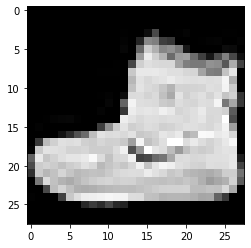

In [80]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [81]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들'
                '셔츠', '스니커즈', '가방', '앵클부츠']
              

In [82]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                          stratify=y_train_all, test_size=0.2, random_state=42)


In [83]:
x_train = x_train / 255
x_val = x_val / 255
print(x_train.shape)

(48000, 28, 28)


In [84]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [85]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [86]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded,
       x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

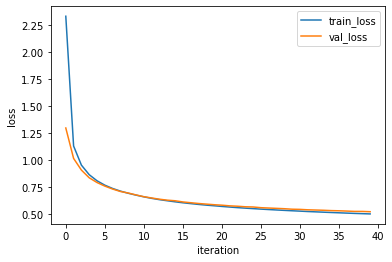

In [88]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [89]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

# 케라스로 구현

In [100]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [102]:
history = model.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 5s 104us/sample - loss: 1.3950 - accuracy: 0.6359 - val_loss: 0.9738 - val_accuracy: 0.7190
Epoch 2/40
48000/48000 [==============================] - 4s 89us/sample - loss: 0.8502 - accuracy: 0.7446 - val_loss: 0.7580 - val_accuracy: 0.7558
Epoch 3/40
48000/48000 [==============================] - 4s 87us/sample - loss: 0.7166 - accuracy: 0.7662 - val_loss: 0.6683 - val_accuracy: 0.7794
Epoch 4/40
48000/48000 [==============================] - 4s 87us/sample - loss: 0.6500 - accuracy: 0.7802 - val_loss: 0.6184 - val_accuracy: 0.7885
Epoch 5/40
48000/48000 [==============================] - 4s 89us/sample - loss: 0.6074 - accuracy: 0.7921 - val_loss: 0.5799 - val_accuracy: 0.8020
Epoch 6/40
48000/48000 [==============================] - 4s 89us/sample - loss: 0.5766 - accuracy: 0.8039 - val_loss: 0.5526 - val_accuracy: 0.8101
Epoch 7/40
48000/48000 [==============================]

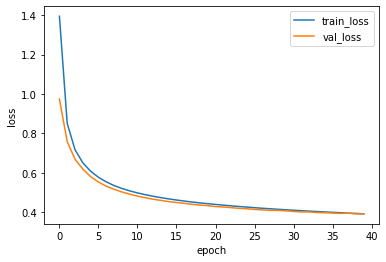

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

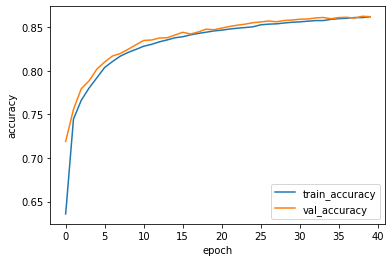

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [105]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8620833
